Energy: tensor(-2.8282)


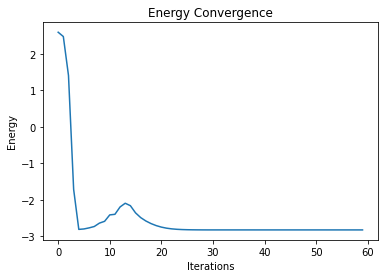

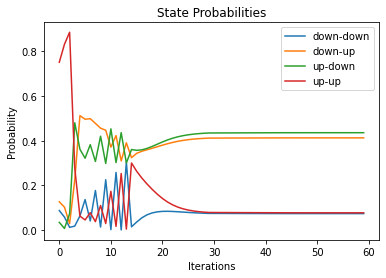

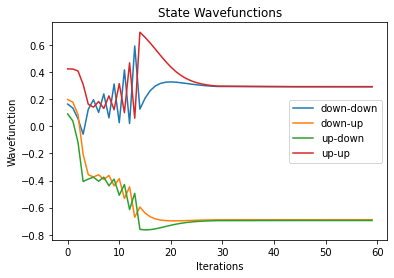

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Author: Caleb Sanders

Demonstrate energy convergence with the transverse ising model hamiltonian.
"""

import itertools
import time
import matplotlib.pyplot as plt
from NADE_Network import *
 
H = "transverse ising"
B = 1 #sigma_x term activation
J = 1 #sigma_z term activation 

states = [
    torch.tensor([-1,-1], dtype=torch.float),
    torch.tensor([-1,1], dtype=torch.float),
    torch.tensor([1,-1], dtype=torch.float),
    torch.tensor([1,1], dtype=torch.float)
]

# network initialization 
inputs = 2
hidden_nodes = 6
network = NADE_Network(inputs, hidden_nodes)

# statistics to track for each state 
energies = []
prob1 = []; prob2 = []; prob3 = []; prob4 = [];
wave1 = []; wave2 = []; wave3 = []; wave4 = [];
output1 = []; output2 = [];

# training hyperparameters 
iters = 60
lr = 0.3
lr_scheduler = 15 #number of iterations after which to decrease the learning rate 
lr_factor = 10 #factory by which to decrease the learning rate 

# training loop
for iter in range(iters):

    #learning rate scheduler
    if (iter+1)%lr_scheduler == 0:
        lr = lr/lr_factor 

    sample_grads = [[]]*len(states); psi_omega = []; O_k = []; epsilons = []; probs = []; waves = []

    for sample in range(0,len(states)):

        # get psi, probabilities, and network outputs 
        psi_data = network.calculate_joint_psi(states[sample])
        psi = psi_data['psi']
        output1.append(psi_data['out1'])
        output2.append(psi_data['out2'])
        prob = network.get_state_probability(states[sample])

        psi_omega.append(psi)
        probs.append(prob)
        waves.append(psi)

        # get epsilon
        epsilon = network.get_epsilon(states[sample], psi, H, B, J)
        epsilons.append(float(epsilon))

        # get state gradient
        masked_state = torch.zeros(network.n_visible)
        for i in range(0, network.n_visible):
            
            out1, out2 = network(masked_state)
            network.zero_grad()

            if states[sample][i] == -1:
                out2.backward()
                current_param_grads = [ p.grad/out2 for p in network.parameters() ]
            else:
                out1.backward()
                current_param_grads = [ p.grad/out1 for p in network.parameters() ]

            # if this is the first bit to be sampled, set the sample gradients to the current gradients 
            if i == 0:
                sample_grads[sample] = current_param_grads

            # else, add the new gradients to the running sum for this sample 
            else:
                for (grad,add_grad) in zip(sample_grads[sample], current_param_grads):
                    grad.copy_(grad.clone() + add_grad)

            masked_state[i] = states[sample][i]

    prob1.append(probs[0]); prob2.append(probs[1]); prob3.append(probs[2]); prob4.append(probs[3]);
    wave1.append(waves[0]); wave2.append(waves[1]); wave3.append(waves[2]); wave4.append(waves[3]);

    psi_omega = torch.tensor(psi_omega)
    epsilons = torch.tensor(epsilons)

    energy = torch.matmul(psi_omega**2, epsilons)/sum(psi_omega**2)
    energies.append(energy)
    
    # compute O_k, of dimension (n_spins, n_params)
    for spin_grad in sample_grads:

        # mini_arr contains the O_k values for a given spin state  
        mini_tens = torch.tensor([])

        #calculate the O_k value for each parameter 
        for grad in spin_grad:

            O_k_s = grad.flatten()
            mini_tens = torch.cat((mini_tens, grad.flatten()))

        O_k.append(mini_tens)

    O_k = torch.stack(O_k)
    
    # e_grad = <O_k * epsilons> - <O_k> * <epsilons>
    Ok_eps_prod = torch.stack([epsilons[i]*O_k[i] for i in range(0, len(O_k))])   
    e_grad = torch.matmul(Ok_eps_prod.T, psi_omega**2) - torch.matmul(O_k.T, psi_omega**2) * energy

    network.update_grads(e_grad, lr)

final_energy = energies[len(energies)-1]

print("Energy: " + str(final_energy))
plt.plot(energies)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Convergence")
plt.show()

plt.plot(prob1, label="down-down")
plt.plot(prob2, label="down-up")
plt.plot(prob3, label="up-down")
plt.plot(prob4, label='up-up')
plt.legend()
plt.title("State Probabilities")
plt.ylabel("Probability")
plt.xlabel("Iterations")
plt.show()

plt.plot(wave1, label="down-down")
plt.plot(wave2, label="down-up")
plt.plot(wave3, label="up-down")
plt.plot(wave4, label="up-up")
plt.legend()
plt.title("State Wavefunctions")
plt.xlabel("Iterations")
plt.ylabel("Wavefunction")
plt.show()

In [43]:
""" Code to check the network outputs """
# iter = 0
# for i in range(len(output1)):
#     print(output1[i])
#     if (i+1)%4 == 0:
#         print(iter)
#         iter +=1
#         print("\n")